In [1]:
import numpy as np
import pandas as pd
from main import OncoNode,OncoTree
from IPython.display import Image
from util import calc_pair_mat, plot_df, s_softmax
import pickle
from copy import deepcopy
from scipy.special import logsumexp
import time

In [2]:
np.random.seed(1)
root = OncoNode(genes=[], f=1)
c0 = OncoNode(parent=root, genes=[0], f=0.9)
c1 = OncoNode(parent=root, genes=[1], f=0.8)
c2 = OncoNode(parent=root, genes=[2], f=0.3)
c3 = OncoNode(parent=root, genes=[3], f=0.5)
c4 = OncoNode(parent=root, genes=[4,5], f=0.2)
c5 = OncoNode(parent=root, genes=[6,7,8], f=0.8)
c6 = OncoNode(parent=root, genes=[9], f=0.8)
c7 = OncoNode(parent=root, genes=[10,11], f=0.9)
c60 = OncoNode(parent=c6, genes=[12,13], f=0.5)
c61 = OncoNode(parent=c6, genes=[14,15], f=0.7)
c62 = OncoNode(parent=c6, genes=[16], f=0.3)
c70 = OncoNode(parent=c7, genes=[17,18], f=0.4)
c71 =  OncoNode(parent=c7, genes=[19], f=0.3)
c600 = OncoNode(parent=c60, genes=[20], f=0.5)
c610 = OncoNode(parent=c61, genes=[21], f=0.8)
c611 = OncoNode(parent=c61, genes=[22, 23], f=0.7)
c620 = OncoNode(parent=c62, genes=[24], f=0.3)
c700 = OncoNode(parent=c70, genes=[25], f=0.8)
c701 = OncoNode(parent=c70, genes=[26, 27], f=0.3)
gen_progmo = OncoTree([root, c0, c1, c2, c3, c4, c5, c6, c7, c60, c61, c62, c70, c71, c600, c610, c611, c620, c700, c701], pfp=0.02, pfn=0.02)

In [3]:
n_tumors = 400
dataset_dic, weights_dic =gen_progmo.draw_sample(n_tumors)

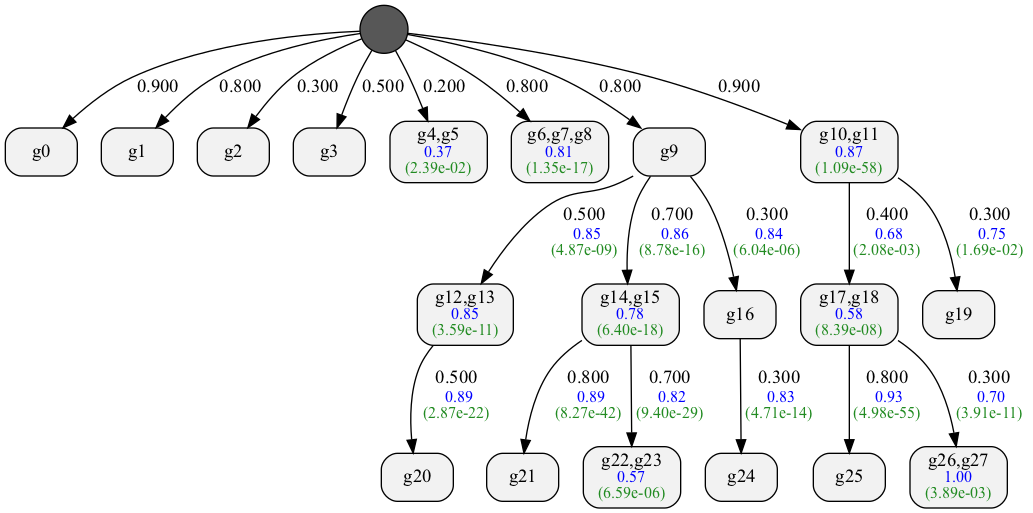

In [4]:
gen_progmo.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_gen.png')
Image('demo/demo_gen.png')

In [5]:
dataset=np.concatenate([dataset_dic[key] for key in dataset_dic.keys()])

In [6]:
MI_scores,MI_log_pvalues, ME_log_pvalues = calc_pair_mat(dataset)
with open('demo/pairmats.pkl', 'wb') as f:
    pickle.dump((MI_scores,MI_log_pvalues, ME_log_pvalues), f)

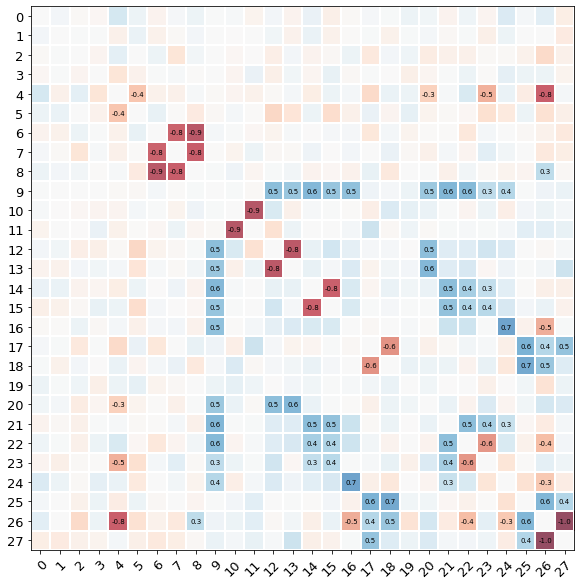

In [7]:
fig = plot_df(pd.DataFrame(MI_scores), vmin=-1, vmax=1, fontsize=7, good_to_print=lambda x: np.abs(x)>0.3)

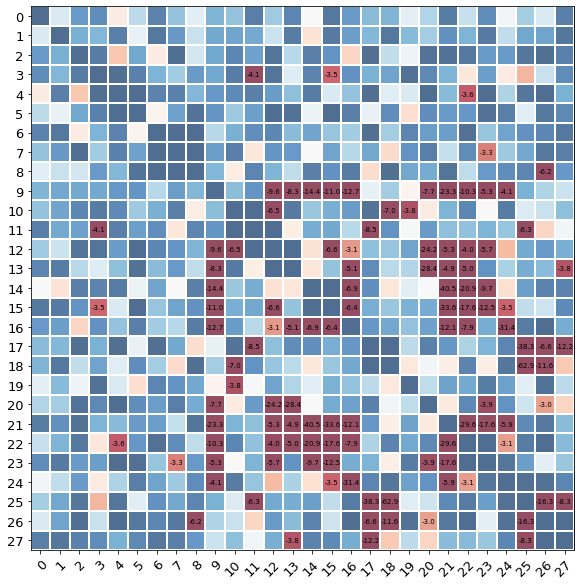

In [8]:
fig = plot_df(pd.DataFrame(MI_log_pvalues), vmin=-4, vmax=0, fontsize=7, good_to_print=lambda x: x<-3)

In [9]:
with open('demo/pairmats.pkl', 'rb') as f:
    MI_scores,MI_log_pvalues, ME_log_pvalues = pickle.load(f)

In [10]:
sample = OncoTree.star_from_dataset(dataset_dic,weights_dic)

# 1- Horizontal Merge
* Forward Kernel:
    * Select a pair of sibling with weights:
        * *proportional to **inverse** of averaged ME-p-values among two siblings' genes*
        * *(Lower p-values) -> (better ME if they join) -> (higher chance of selection)*
* Backward Kernel:
    * Select a node which:
        * Is a leaf node
        * Has at least two genes
    * With weights:
        * *proportional to averaged ME-p-values among the genes in the node*
        * *(Higher p-values) -> (worse set of genes) -> (higher chance of selection)*
    * Partition the genes in it into two non-empty subsets (uniformly)

Candidates:
0) W: 0.0310 -> {0} and {1}
1) W: 0.0597 -> {0} and {2}
2) W: 0.0829 -> {0} and {3}
3) W: 0.0300 -> {0} and {4,5}
4) W: 0.0434 -> {0} and {6,7,8}
5) W: 0.0438 -> {1} and {2}
6) W: 0.0416 -> {1} and {3}
7) W: 0.0470 -> {1} and {4,5}
8) W: 0.0568 -> {1} and {6,7,8}
9) W: 0.1410 -> {2} and {3}
10) W: 0.0336 -> {2} and {4,5}
11) W: 0.0438 -> {2} and {6,7,8}
12) W: 0.1951 -> {3} and {4,5}
13) W: 0.0436 -> {3} and {6,7,8}
14) W: 0.0559 -> {4,5} and {6,7,8}
15) W: 0.0254 -> {21} and {22,23}
16) W: 0.0254 -> {25} and {26,27}
Selected candidate index: 9
Backward Candidates:
0) W: 0.4297 -> {2,3}
1) W: 0.2951 -> {4,5}
2) W: 0.0004 -> {6,7,8}
3) W: 0.0642 -> {22,23}
4) W: 0.2106 -> {26,27}
Backward Probability, part one: 0.4297
Backward Probability, part two: 1.0000
Forward prob: 0.14101
Backward prob: 0.42970


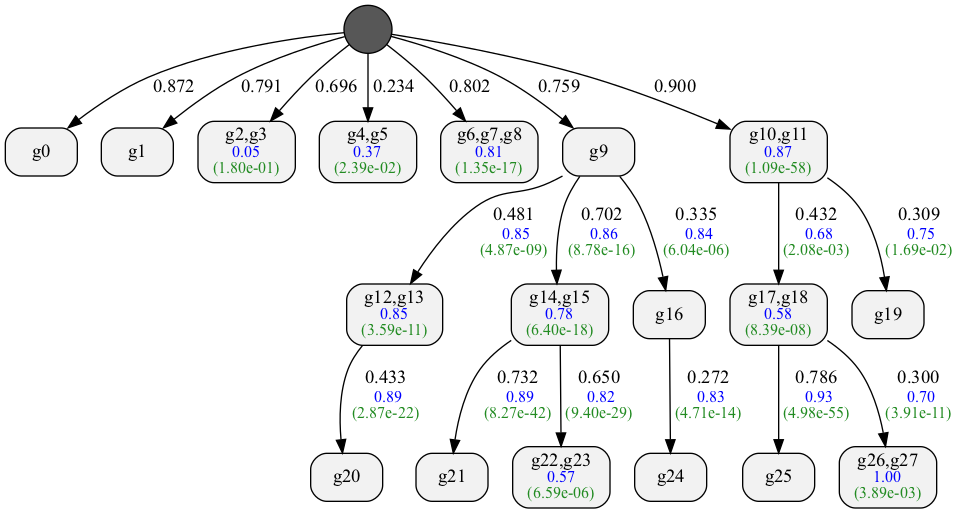

In [11]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.hmerge(
    dataset_dic, weights_dic, ME_log_pvalues, error_estimation=False, debugging=True
)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_hmerge.png')
Image('demo/demo_hmerge.png')

In [12]:
proposal.likelihood(dataset_dic, weights_dic)

-4917.210246979102

# 2- Horizontal Split
* Forward Kernel:
    * Select a node which:
        * Is a leaf node
        * Has at least two genes
    * With weights:
        * *proportional to averaged ME-p-values among the genes in the node*
        * *(Higher p-values) -> (worse set of genes) -> (higher chance of selection)*
    * Partition the genes in it into two non-empty subsets (uniformly)
* Backward Kernel:
    * Select a pair of sibling with weights:
        * *proportional to **inverse** of averaged ME-p-values among two siblings' genes*
        * *(Lower p-values) -> (better ME if they join) -> (higher chance of selection)*

Candidates:
0) W: 0.5262 -> {4,5}
1) W: 0.0005 -> {6,7,8}
2) W: 0.1049 -> {22,23}
3) W: 0.3683 -> {26,27}
Selected candidate index:  3
Selected subset: {26}
Backward Candidates:
0) W: 0.0041 -> {0} and {1}
1) W: 0.0079 -> {0} and {2}
2) W: 0.0110 -> {0} and {3}
3) W: 0.0040 -> {0} and {4,5}
4) W: 0.0057 -> {0} and {6,7,8}
5) W: 0.0058 -> {1} and {2}
6) W: 0.0055 -> {1} and {3}
7) W: 0.0062 -> {1} and {4,5}
8) W: 0.0075 -> {1} and {6,7,8}
9) W: 0.0187 -> {2} and {3}
10) W: 0.0045 -> {2} and {4,5}
11) W: 0.0058 -> {2} and {6,7,8}
12) W: 0.0258 -> {3} and {4,5}
13) W: 0.0058 -> {3} and {6,7,8}
14) W: 0.0074 -> {4,5} and {6,7,8}
15) W: 0.0034 -> {21} and {22,23}
16) W: 0.0034 -> {25} and {27}
17) W: 0.0034 -> {25} and {26}
18) W: 0.8641 -> {27} and {26}
Backward Probability: 0.8641
Forward prob: 0.36831
Backward prob: 0.86414


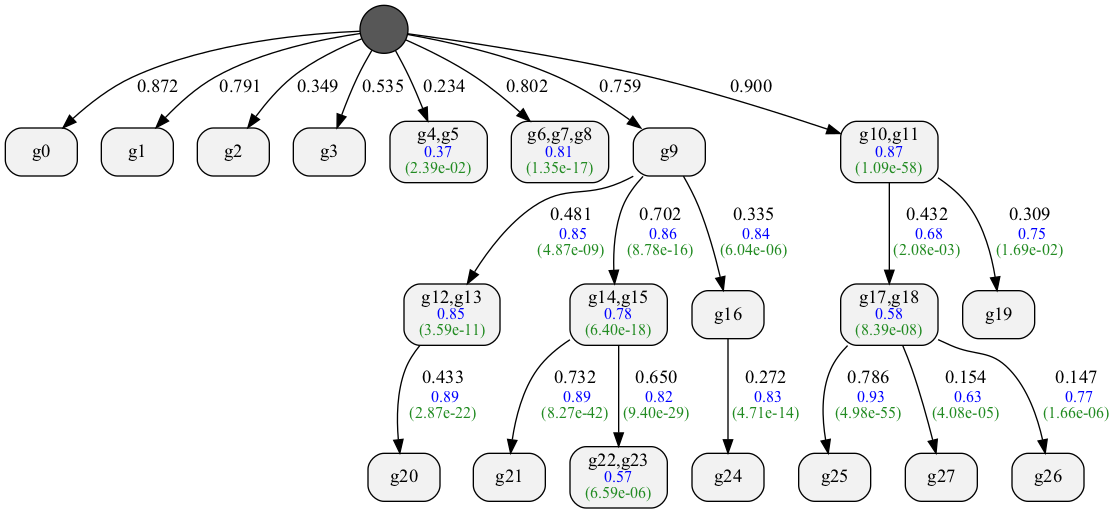

In [13]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.hsplit(
    dataset_dic, weights_dic, ME_log_pvalues, error_estimation=False, debugging=True
)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_hsplit.png')
Image('demo/demo_hsplit.png')

# 3- Vertical Merge
* Forward Kernel:
    * Select a leaf, not in the first level (the parent should include genes), with weights:
        * *proportional to **inverse** of averaged ME-p-values among the genes in the node and its parent*
        * *(Lower p-values) -> (better ME if they join) -> (higher chance of selection)*
* Backward Kernel:
    * Select a node which has at least two genes
    * With weights:
        * *proportional to averaged ME-p-values among the genes in the node*
        * *(Higher p-values) -> (worse set of genes) -> (higher chance of selection)*
    * Select a non-empty, non-full subset of its genes to pass to a new child (uniformly)

Candidates:
0) W: 0.1511 -> {19} and {10,11}
1) W: 0.1412 -> {20} and {12,13}
2) W: 0.1412 -> {21} and {14,15}
3) W: 0.1412 -> {22,23} and {14,15}
4) W: 0.1412 -> {24} and {16}
5) W: 0.1412 -> {25} and {17,18}
6) W: 0.1427 -> {26,27} and {17,18}
Selected candidate index: 6
Backward Candidates:
0) W: 0.2851 -> {4,5}
1) W: 0.0461 -> {6,7,8}
2) W: 0.0003 -> {10,11}
3) W: 0.0993 -> {12,13}
4) W: 0.0443 -> {14,15}
5) W: 0.3387 -> {17,18,26,27}
6) W: 0.1863 -> {22,23}
Backward Probability, part one: 0.3387
Backward Probability, part two: 0.0714
Forward prob: 0.14271
Backward prob: 0.02419


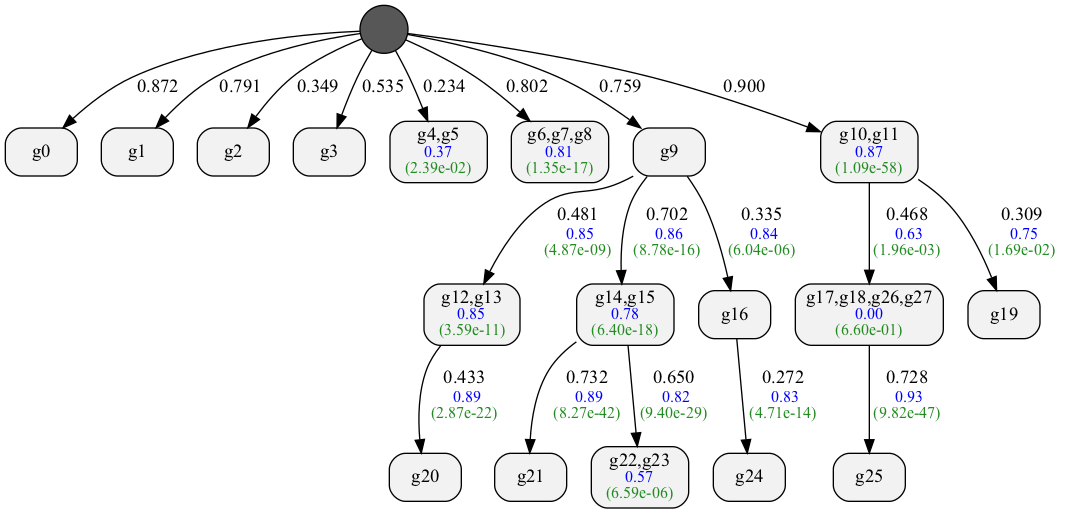

In [14]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.vmerge(
    dataset_dic, weights_dic, ME_log_pvalues, error_estimation=False, debugging=True
)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_vmerge.png')
Image('demo/demo_vmerge.png')

# 4- Vertical Split
* Forward Kernel:
    * Select a node which has at least two genes
    * With weights:
        * *proportional to averaged ME-p-values among the genes in the node*
        * *(Higher p-values) -> (worse set of genes) -> (higher chance of selection)*
    * Select a non-empty, non-full subset of its genes to pass to a new child (uniformly)
* Backward Kernel:
    * Select a leaf, not in the first level (the parent should include genes), with weights:
        * *proportional to **inverse** of averaged ME-p-values among the genes in the node and its parent*
        * *(Lower p-values) -> (better ME if they join) -> (higher chance of selection)*

Candidates:
0) W: 0.2696 -> {4,5}
1) W: 0.0416 -> {6,7,8}
2) W: 0.0003 -> {10,11}
3) W: 0.0914 -> {12,13}
4) W: 0.0400 -> {14,15}
5) W: 0.1381 -> {17,18}
6) W: 0.1743 -> {22,23}
7) W: 0.2448 -> {26,27}
Selected candidate index:  4
Selected subset: {15}
Backward Candidates:
0) W: 0.0010 -> {19} and {10,11}
1) W: 0.0010 -> {20} and {12,13}
2) W: 0.0010 -> {21} and {14}
3) W: 0.0010 -> {22,23} and {14}
4) W: 0.0010 -> {24} and {16}
5) W: 0.0010 -> {25} and {17,18}
6) W: 0.0010 -> {26,27} and {17,18}
7) W: 0.9930 -> {15} and {14}
Backward Probability: 0.9930
Forward prob: 0.01998
Backward prob: 0.99304


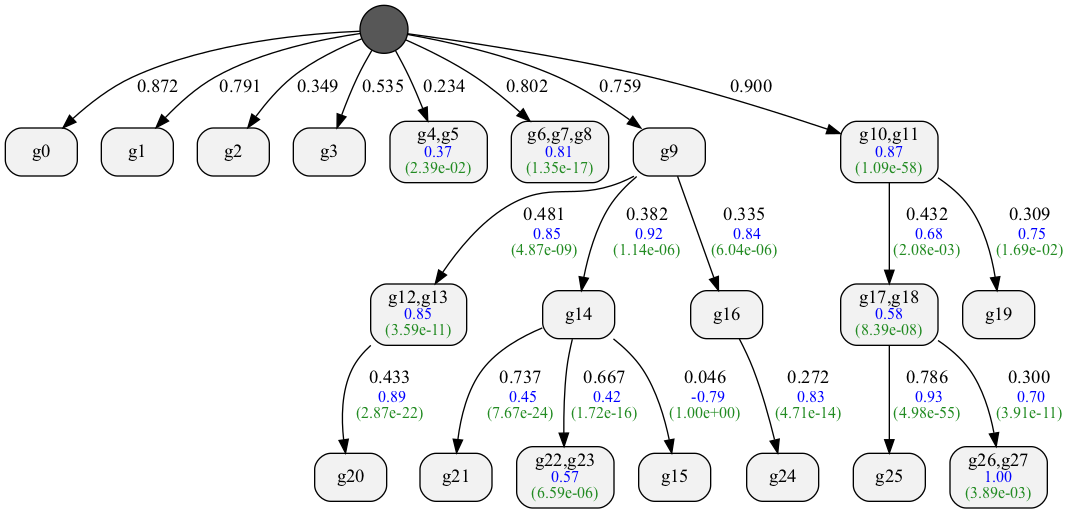

In [15]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.vsplit(
    dataset_dic, weights_dic, ME_log_pvalues, error_estimation=True, debugging=True
)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_vsplit.png')
Image('demo/demo_vsplit.png')

# 5- Swap Genes
* Forward Kernel:
    * Select a node not in the first layer (the parent should include genes), without weight
* Backward Kernel:
    * Equal forward and backward probs, hence, no need for calculations

Candidates:
0) W: 0.0023 -> {12,13}
1) W: 0.0039 -> {14,15}
2) W: 0.0048 -> {16}
3) W: 0.0006 -> {17,18}
4) W: 0.0007 -> {19}
5) W: 0.0430 -> {20}
6) W: 0.2380 -> {21}
7) W: 0.0035 -> {22,23}
8) W: 0.1403 -> {24}
9) W: 0.5618 -> {25}
10) W: 0.0010 -> {26,27}
Selected node: {21}
Forward prob: 1.00000
Backward prob: 1.00000


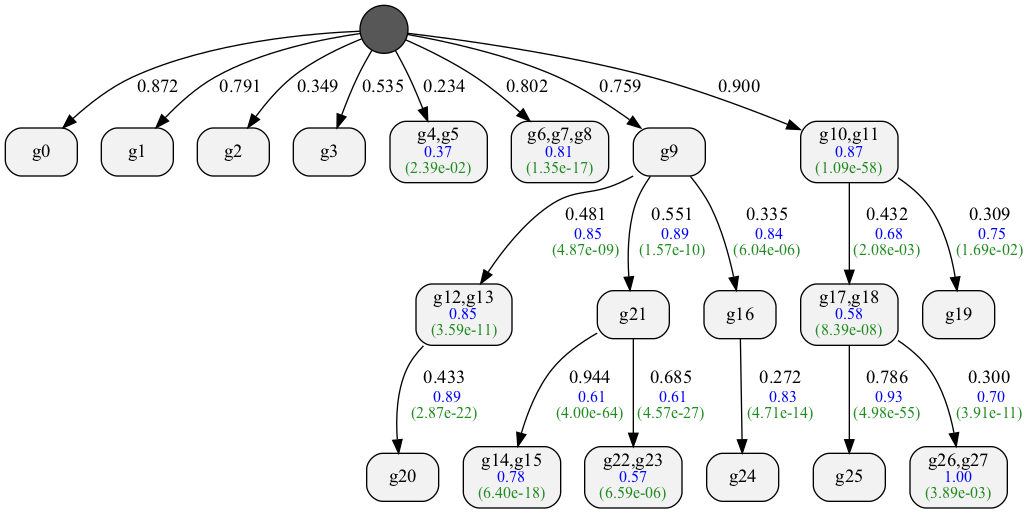

In [16]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.swap(dataset_dic, weights_dic, MI_log_pvalues=MI_log_pvalues, error_estimation=False, debugging=True)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_swap.png')
Image('demo/demo_swap.png')

In [17]:
len([i for i in range(dataset.shape[0]) if (dataset[i, [17,18]].sum()>0) and (dataset[i, 25])])

256

# 6- SPR (Subtree Pruning and Regrafting)
* Forward Kernel:
    * Select a node (not root)
    * Select a parent node that
        * is not in the selected node's subtree (including itself)
        * is not root
    * With weights:
        * *proportional to the averaged MI-p-values with the destination*
        * *(lower p-values) -> (better MI score if they connect) -> higher chance of selection*

Candidates:
0) W: 0.0526 -> {0}
1) W: 0.0526 -> {1}
2) W: 0.0526 -> {2}
3) W: 0.0526 -> {3}
4) W: 0.0526 -> {4,5}
5) W: 0.0526 -> {6,7,8}
6) W: 0.0526 -> {9}
7) W: 0.0526 -> {10,11}
8) W: 0.0526 -> {12,13}
9) W: 0.0526 -> {14,15}
10) W: 0.0526 -> {16}
11) W: 0.0526 -> {17,18}
12) W: 0.0526 -> {19}
13) W: 0.0526 -> {20}
14) W: 0.0526 -> {21}
15) W: 0.0526 -> {22,23}
16) W: 0.0526 -> {24}
17) W: 0.0526 -> {25}
18) W: 0.0526 -> {26,27}
Selected node: {6,7,8}
Parent Candidates:
0) W: 0.0526 -> {}
1) W: 0.0526 -> {0}
2) W: 0.0526 -> {1}
3) W: 0.0526 -> {2}
4) W: 0.0526 -> {3}
5) W: 0.0526 -> {4,5}
6) W: 0.0526 -> {9}
7) W: 0.0526 -> {10,11}
8) W: 0.0526 -> {12,13}
9) W: 0.0526 -> {14,15}
10) W: 0.0526 -> {16}
11) W: 0.0526 -> {17,18}
12) W: 0.0526 -> {19}
13) W: 0.0526 -> {20}
14) W: 0.0526 -> {21}
15) W: 0.0526 -> {22,23}
16) W: 0.0526 -> {24}
17) W: 0.0526 -> {25}
18) W: 0.0526 -> {26,27}
Selected parent: {16}
Forward prob: 0.00277
Backward prob: 0.00277


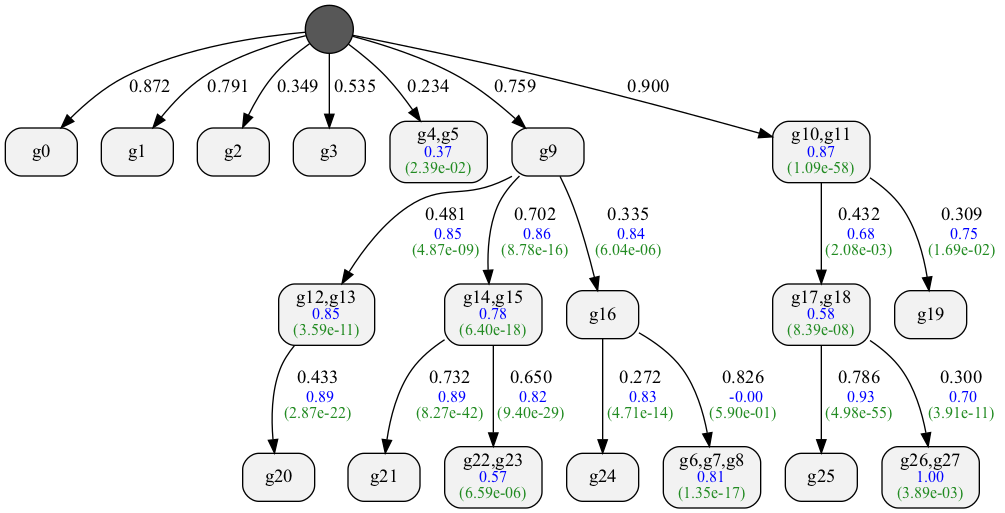

In [18]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.spr(
    dataset_dic, weights_dic, MI_log_pvalues=None, error_estimation=False, debugging=True
)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_spr.png')
Image('demo/demo_spr.png')

# 7- Gene Transfer
* Forward Kernel:
    * Select a gene that has at least one co-cluster:
        * *proportional to averaged ME-p-values among the gene and its co-cluster genes times progression-p-values to parent and child genes*
        * *(Higher p-values) -> (worse gene) -> (higher chance of selection)*
    * Select a destination based on the new relations that it creates

Candidates:
0) W: 0.1714 -> 4
1) W: 0.1714 -> 5
2) W: 0.0266 -> 6
3) W: 0.0266 -> 7
4) W: 0.0193 -> 8
5) W: 0.0002 -> 10
6) W: 0.0002 -> 11
7) W: 0.0121 -> 12
8) W: 0.0104 -> 13
9) W: 0.0084 -> 14
10) W: 0.0086 -> 15
11) W: 0.0718 -> 17
12) W: 0.0868 -> 18
13) W: 0.0471 -> 22
14) W: 0.0720 -> 23
15) W: 0.1198 -> 26
16) W: 0.1474 -> 27
Selected gene: {6}
Dest Candidates:
0) W: 0.0021 -> {0}
1) W: 0.0023 -> {1}
2) W: 0.0016 -> {2}
3) W: 0.0018 -> {3}
4) W: 0.0018 -> {4,5}
5) W: 0.9738 -> {6,7,8}
6) W: 0.0013 -> {9}
7) W: 0.0013 -> {10,11}
8) W: 0.0011 -> {12,13}
9) W: 0.0010 -> {14,15}
10) W: 0.0010 -> {16}
11) W: 0.0010 -> {17,18}
12) W: 0.0015 -> {19}
13) W: 0.0013 -> {20}
14) W: 0.0014 -> {21}
15) W: 0.0015 -> {22,23}
16) W: 0.0014 -> {24}
17) W: 0.0014 -> {25}
18) W: 0.0015 -> {26,27}
Selected dest: {6,7,8}
Backward Candidates:
0) W: 0.1714 -> 4
1) W: 0.1714 -> 5
2) W: 0.0266 -> 7
3) W: 0.0193 -> 8
4) W: 0.0266 -> 6
5) W: 0.0002 -> 10
6) W: 0.0002 -> 11
7) W: 0.0121 -> 12
8) W: 0.010

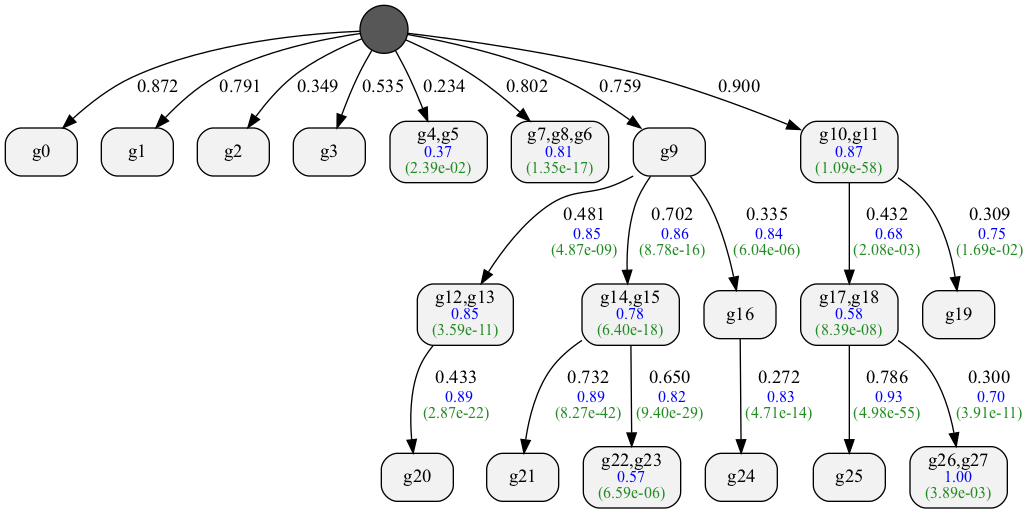

In [19]:
proposal, forward_prob, backward_prob, novel_proposal = gen_progmo.gt(
    dataset_dic, weights_dic, MI_log_pvalues, ME_log_pvalues, error_estimation=False, debugging=True
)
print("Forward prob: %.5f"%np.exp(forward_prob))
print("Backward prob: %.5f"%np.exp(backward_prob))
proposal.to_dot(dataset_dic, weights_dic, fig_file='demo/demo_gt.png')
Image('demo/demo_gt.png')